Команда внедрила в приложение умную систему рекомендации товаров – предполагается, что такая система поможет пользователям эффективнее работать с приложением и лучше находить необходимые товары.

Чтобы проверить эффективность системы рекомендаций, был проведен АБ-тест. В группе 1 оказались пользователи с новой системой рекомендаций, в группе 0 пользователи со старой версией приложения, где нет рекомендации товаров.

Задача – оценить, смогла ли новая система рекомендаций принести пользу бизнесу и пользователям приложения. Для этого нужно выбрать метрики, которые отвечают за качество сервиса, и статистически сравнить эти метрики в двух группах.

In [109]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import bootstrap

Смотрим на данные, которые у нас есть, и делаем их предобработку.

In [2]:
orders = pd.read_csv('ab_orders.csv')
orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56.000000,"{74, 6}"
4,1259,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"


In [13]:
# для удобства преобразуем словарь в список product_ids
orders.product_ids = orders.product_ids.apply(lambda x: x.replace('{','').replace('}','').split(', '))
orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"[75, 22, 53, 84]"
1,1256,2022-08-26 00:02:21.000000,"[56, 76, 39]"
2,1257,2022-08-26 00:02:27.000000,"[76, 34, 41, 38]"
3,1258,2022-08-26 00:02:56.000000,"[74, 6]"
4,1259,2022-08-26 00:03:37.000000,"[20, 45, 67, 26]"


In [3]:
products = pd.read_csv('ab_products.csv')
products.head()

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0


In [12]:
users = pd.read_csv('ab_users_data.csv', parse_dates=['time', 'date'])
users.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37,2022-08-26,1


In [14]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4337 entries, 0 to 4336
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   4337 non-null   int64         
 1   order_id  4337 non-null   int64         
 2   action    4337 non-null   object        
 3   time      4337 non-null   datetime64[ns]
 4   date      4337 non-null   datetime64[ns]
 5   group     4337 non-null   int64         
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 203.4+ KB


In [20]:
# объединим две таблицы users и orders
users_orders = users.merge(orders, on='order_id')
users_orders.isna().sum()

user_id          0
order_id         0
action           0
time             0
date             0
group            0
creation_time    0
product_ids      0
dtype: int64

In [21]:
users_orders.head(10)

,user_id,order_id,action,time,date,group,creation_time,product_ids
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,"[75, 22, 53, 84]"
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,2022-08-26 00:02:21.000000,"[56, 76, 39]"
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0,2022-08-26 00:02:27.000000,"[76, 34, 41, 38]"
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0,2022-08-26 00:02:56.000000,"[74, 6]"
4,966,1258,cancel_order,2022-08-26 00:08:25.486419,2022-08-26,0,2022-08-26 00:02:56.000000,"[74, 6]"
5,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1,2022-08-26 00:03:37.000000,"[20, 45, 67, 26]"
6,968,1261,create_order,2022-08-26 00:05:35.000000,2022-08-26,0,2022-08-26 00:05:35.000000,"[30, 35, 69, 6]"
7,969,1262,create_order,2022-08-26 00:06:25.000000,2022-08-26,0,2022-08-26 00:06:25.000000,"[23, 69, 45, 33]"
8,970,1263,create_order,2022-08-26 00:08:22.000000,2022-08-26,1,2022-08-26 00:08:22.000000,"[22, 23, 5]"
9,971,1264,create_order,2022-08-26 00:10:53.000000,2022-08-26,1,2022-08-26 00:10:53.000000,"[60, 5, 33, 69]"


In [24]:
# сколько отмененных заказов
users_orders.action.value_counts()

create_order    4123
cancel_order     214
Name: action, dtype: int64

In [25]:
# у нас есть отменные заказы, поэтому исключим их 
users_orders = users_orders.query("action != 'cancel_order'")

In [26]:
users_orders.action.value_counts()

create_order    4123
Name: action, dtype: int64

Я думаю, что в качестве одного из показателей нам может понадобиться количество купленных товаров. Поэтому добавим новый столбец, где будет указано количество товаров в заказе.

In [30]:
users_orders['quantity_products'] = users_orders.product_ids.apply(lambda x: len(x))
users_orders.head()

,user_id,order_id,action,time,date,group,creation_time,product_ids,quantity_products
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19.000000,"[75, 22, 53, 84]",4
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1,2022-08-26 00:02:21.000000,"[56, 76, 39]",3
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,0,2022-08-26 00:02:27.000000,"[76, 34, 41, 38]",4
3,966,1258,create_order,2022-08-26 00:02:56,2022-08-26,0,2022-08-26 00:02:56.000000,"[74, 6]",2
5,967,1259,create_order,2022-08-26 00:03:37,2022-08-26,1,2022-08-26 00:03:37.000000,"[20, 45, 67, 26]",4


In [32]:
# так как у нас есть стоимость товара, делаем предобразование в список product_id и price и делаем словарь 
product_ids = products.product_id.to_list()
product_prices = products.price.to_list()
dict_product = dict(zip(product_ids,product_prices))

In [50]:
# Функция для извлечения списка стоимости товаров по списку product_id 

def return_price(products_id, dict_product):
    price = []
    for i in products_id:
        price.append(dict_product[int(i)])
    return price


In [51]:
# добавляем столбец со стоимостью товаров в заказе
users_orders['product_prices'] = users_orders.product_ids.apply(lambda x: return_price(x,dict_product))
users_orders.head()

,user_id,order_id,action,time,date,group,creation_time,product_ids,quantity_products,product_prices,order_price
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19.000000,"[75, 22, 53, 84]",4,"[120.0, 120.0, 78.3, 90.4]",408.7
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1,2022-08-26 00:02:21.000000,"[56, 76, 39]",3,"[150.0, 55.5, 45.0]",250.5
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,0,2022-08-26 00:02:27.000000,"[76, 34, 41, 38]",4,"[55.5, 98.0, 80.4, 76.3]",310.2
3,966,1258,create_order,2022-08-26 00:02:56,2022-08-26,0,2022-08-26 00:02:56.000000,"[74, 6]",2,"[60.0, 25.0]",85.0
5,967,1259,create_order,2022-08-26 00:03:37,2022-08-26,1,2022-08-26 00:03:37.000000,"[20, 45, 67, 26]",4,"[50.0, 78.0, 30.0, 70.0]",228.0


In [43]:
# еще сделаем новый столбец с общей стоимостью заказа
users_orders['order_price'] = users_orders['product_prices'].apply(lambda x: sum(x))
users_orders.head()

,user_id,order_id,action,time,date,group,creation_time,product_ids,quantity_products,product_prices,order_price
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19.000000,"[75, 22, 53, 84]",4,"[120.0, 120.0, 78.3, 90.4]",408.7
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1,2022-08-26 00:02:21.000000,"[56, 76, 39]",3,"[150.0, 55.5, 45.0]",250.5
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,0,2022-08-26 00:02:27.000000,"[76, 34, 41, 38]",4,"[55.5, 98.0, 80.4, 76.3]",310.2
3,966,1258,create_order,2022-08-26 00:02:56,2022-08-26,0,2022-08-26 00:02:56.000000,"[74, 6]",2,"[60.0, 25.0]",85.0
5,967,1259,create_order,2022-08-26 00:03:37,2022-08-26,1,2022-08-26 00:03:37.000000,"[20, 45, 67, 26]",4,"[50.0, 78.0, 30.0, 70.0]",228.0


In [68]:
# отлично, теперь посмотрим сколько у нас пользователей в каждой группе и заказов
control = users_orders.query('group == 0')
print("Количество пользователей = ", control.user_id.nunique())
print("Количество заказаов =", control.order_id.count())

Количество пользователей =  515
Количество заказаов = 1609


In [69]:
test = users_orders.query('group == 1')
print("Количество пользователей = ", test.user_id.nunique())
print("Количество заказаов =", test.order_id.count())

Количество пользователей =  502
Количество заказаов = 2514


In [96]:
# теперь посмотрим на распределение наших метрик, сгруппировав по группам стоимость заказа и количество заказов.
users_orders_upd = users_orders \
                        .groupby(['user_id','group'], as_index=False) \
                        .agg({'order_price':'sum','quantity_products':'sum'}) \
                        .rename(columns={'order_price':'total_price','quantity_products':'total_products'})
users_orders_upd.head()

,user_id,group,total_price,total_products
0,964,0,718.9,8
1,965,1,4155.5,33
2,966,0,85.0,2
3,967,1,1137.4,18
4,968,0,1590.7,11


In [99]:
users_orders_upd.query('group == 0').total_price.describe()

count     515.000000
mean     1191.240388
std       829.633729
min        25.000000
25%       605.250000
50%       999.400000
75%      1553.200000
max      5589.800000
Name: total_price, dtype: float64

In [100]:
users_orders_upd.query('group == 1').total_price.describe()

count     502.000000
mean     1851.059761
std       953.669817
min        83.500000
25%      1191.725000
50%      1710.300000
75%      2435.975000
max      4742.200000
Name: total_price, dtype: float64

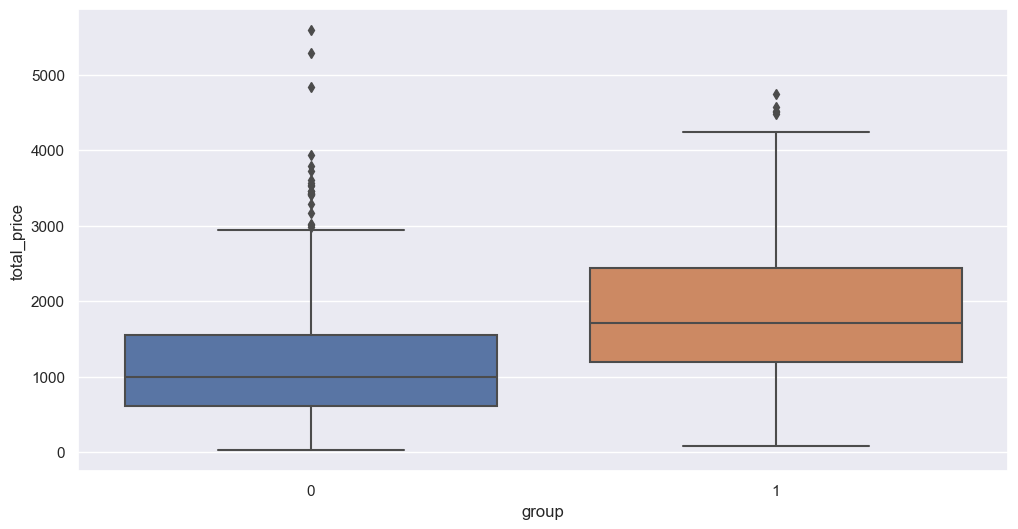

In [134]:
# посмотрим как это выглядит на boxplot
sns.set(style='darkgrid', rc={'figure.figsize' : (12,6)})
sns.boxplot(y='total_price', x='group', data = users_orders_upd)
plt.show()

Анализ данных позволяет сделать вывод о том, что распределение в группах является асимметричным, что наглядно иллюстрируется на графике. Кроме того, наблюдается, что в тестовой группе значения центральной тенденции и изменчивости выше, чем в контрольной группе. На основании этих наблюдений можно предположить, что данные также обладают асимметрией.

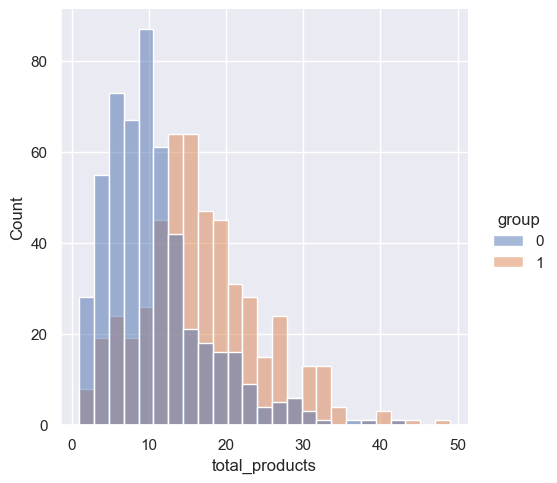

In [108]:
# посмотрим на распределение данных
sns.displot(data=users_orders_upd, x="total_products", hue="group")
plt.show()

Поскольку данные имеют ненормальное распределение, мы проведём анализ средних с использованием метода bootstrap. Это позволит нам увидеть, какие доверительные интервалы есть в группах и пересекаются ли они.

In [111]:
bootstrap((users_orders_upd.query('group == 0').total_price, ), np.mean)

BootstrapResult(confidence_interval=ConfidenceInterval(low=1123.2485236478828, high=1269.4466653430661), standard_error=36.74843165485387)

In [112]:
bootstrap((users_orders_upd.query('group == 1').total_price, ), np.mean)

BootstrapResult(confidence_interval=ConfidenceInterval(low=1769.0365887932749, high=1934.758396499129), standard_error=42.27694890899504)

Исходя из теста доверительные интервалы не пересекаются, что может говорить о статистически значимой разнице между группами по total_price.


Посмотрим, какой доверительный интервал по другой метрике total_products

In [113]:
bootstrap((users_orders_upd.query('group == 0').total_products, ), np.mean)

BootstrapResult(confidence_interval=ConfidenceInterval(low=9.930097087378641, high=11.04939834207827), standard_error=0.286159858574294)

In [114]:
bootstrap((users_orders_upd.query('group == 1').total_products, ), np.mean)

BootstrapResult(confidence_interval=ConfidenceInterval(low=16.11354581673307, high=17.50796812749004), standard_error=0.35618295041393755)

Аналогично, что и с total_price доверительные интервалы не пересекаются это также приводит статистически значимой разнице.

Сделаем дополнительные тесты с помощью bootstrap, чтобы найти доверительные интервалы эффекта различия между группами. Bootstrap возвращает доверительный интервал средних значений, возьмем среднее из полученного доверительного интервала для каждой из групп и найдем их разницу.

In [125]:
diff_mean_total_price = []

for i in range(500):
    control_total_price_mean = stats.bootstrap((users_orders_upd.query('group==0').total_price, ), np.mean)
    test_total_price_mean = stats.bootstrap((users_orders_upd.query('group==1').total_price, ), np.mean)

    control_mean = np.mean([control_total_price_mean.confidence_interval[1], control_total_price_mean.confidence_interval[0]])
    test_mean = np.mean([test_total_price_mean.confidence_interval[1], test_total_price_mean.confidence_interval[0]])

    diff_mean_total_price.append(test_mean - control_mean)


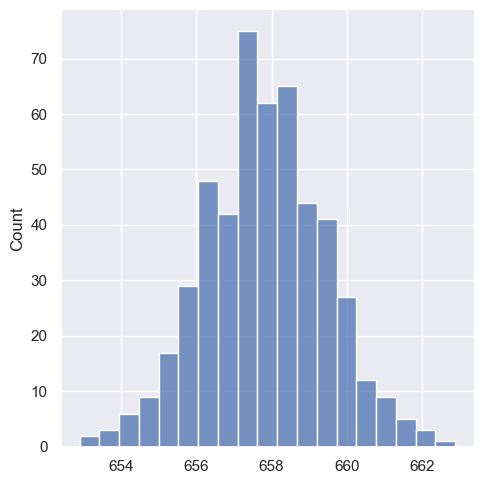

In [126]:
sns.displot(diff_mean_total_price)
plt.show()

In [127]:
# выведем 95% доверительного интервала для среднего значения разницы стоимости общей стоимости заказа между двумя группами.
stats.t.interval(0.95, len(diff_mean_total_price) - 1, loc=np.mean(diff_mean_total_price))

(655.8423816214504, 659.7718404034258)

In [131]:
# проделаем туже операцию, но только по кол-ву продуктов total_products.  
diff_mean_total_products = []

for i in range(500):
    control_total_products_mean = stats.bootstrap((users_orders_upd.query('group == 0').total_products, ), np.mean)
    test_total_products_mean = stats.bootstrap((users_orders_upd.query('group == 1').total_products, ), np.mean)

    control_mean = np.mean([control_total_products_mean.confidence_interval[1], control_total_products_mean.confidence_interval[0]])
    test_mean = np.mean([test_total_products_mean.confidence_interval[1], test_total_products_mean.confidence_interval[0]])

    diff_mean_total_products.append(test_mean - control_mean)


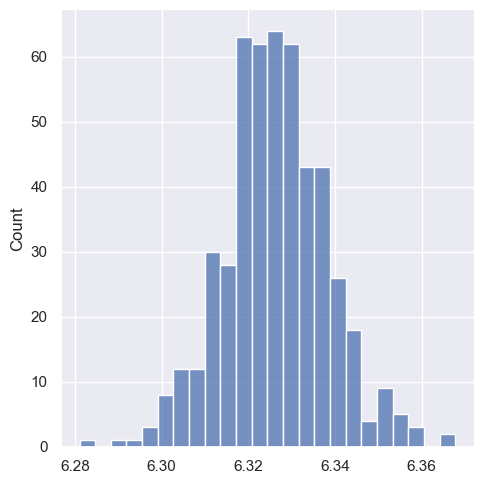

In [132]:
sns.displot(diff_mean_total_products)
plt.show()

In [133]:
stats.t.interval(0.95, len(diff_mean_total_products) - 1, loc=np.mean(diff_mean_total_products))

(4.361594627910298, 8.291053409885627)

## Вывод

На основании проведенного анализа данных A/B-теста можно сделать следующие выводы:

- Средняя сумма заказа в тестовой группе, использующей новую систему рекомендаций товаров, увеличилась примерно на 658 условных единиц по сравнению с контрольной группой.

- Среднее количество товаров в корзине пользователей тестовой группы возросло в среднем на 6 единиц по сравнению с контрольной группой.

Результаты статистического анализа показывают, что разница между группами является статистически значимой. Это означает, что новая система рекомендаций товаров оказывает положительное влияние на поведение пользователей и эффективность продаж.

Таким образом, на основании полученных данных и сделанных выводов, мы рекомендуем внедрить новую систему рекомендаций товаров для всех пользователей мобильного приложения. Это позволит увеличить средний чек, количество товаров в корзине и в целом повысить эффективность продаж.

Внедрение системы рекомендаций также может способствовать улучшению пользовательского опыта, так как она помогает находить и открывать для пользователей новые интересные товары, соответствующие их предпочтениям.

Рекомендую продолжить мониторинг ключевых метрик после полномасштабного внедрения системы рекомендаций, чтобы отслеживать долгосрочные эффекты и при необходимости вносить корректировки в алгоритмы рекомендаций.